In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate
from Engine.DragModel import DragModel

import time

In [2]:
# Initialize GlobalClock to synchronize all agent behaviours
clock = GlobalClock(update_rate=200, stop=100, start=0)

AC1_AircraftType = AircraftType(max_cruise_spd=10)


#---------------------- DIRECT_P2P --> HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0])]
# AC1_Wpt_Start_Time = [0, 25]
# AC1_Wpt_End_List = [np.array([100,0,0]), np.array([100,0,0])]
# AC1_Wpt_End_Time = [25, 125]
# AC1_Mode_List = ['Direct_P2P', 'Hover']
# AC1_Duration_List = [25, 100]
# AC1_Leg_Spd = [5, 0]


#---------------------- DIRECT_P2P TEST FLIGHT PLAN -------------------------
AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0])]
AC1_Wpt_Start_Time = [0, 25]
AC1_Wpt_End_List = [np.array([100,0,0]), np.array([0,0,0])]
AC1_Wpt_End_Time = [25, 50]
AC1_Mode_List = ['Direct_P2P', 'Direct_P2P']
AC1_Duration_List = [25, 50]
AC1_Leg_Spd = [5, 5]

#---------------------- HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([10,0,0]), np.array([10,0,0])]
# AC1_Wpt_Start_Time = [0, 100]
# AC1_Wpt_End_List = [np.array([10,0,0]), np.array([10,0,0])]
# AC1_Wpt_End_Time = [100, 200]
# AC1_Mode_List = ['Hover', 'Hover']
# AC1_Duration_List = [100, 100]
# AC1_Leg_Spd = [0, 0]

AC1_FlightPlan = FlightPlan(AC1_Leg_Spd,
                            AC1_Mode_List,
                            AC1_Wpt_Start_List, AC1_Wpt_Start_Time,
                            AC1_Wpt_End_List, AC1_Wpt_End_Time, AC1_Duration_List)

AC1_PhysicsUpdateRate = 200
AC1_Controller_UpdateRate = 50
AC1_Start_Time = 0

AC1_Controller = MultiRotorController(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

Wind = WindField(5, 0)

AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_Ini_Pos = np.array([0,0,0])
AC1_Ini_Vel = np.array([0,0,0])
AC1_Ini_Pos_Err = np.array([0,0,0])
AC1_Ini_Vel_Err = np.array([0,0,0])
AC1_Ini_RPY = np.array([0,0,0])


AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_PosUpdateRate = 100
AC1_VelUpdateRate = 100
AC1_AccelUpdateRate = 100
AC1_AirSpdSensorUpdateRate = 100

AC1_Pos_Nav_Agent = NavUpdate(AC1_PosUpdateRate, AC1_Start_Time)
AC1_Vel_Nav_Agent = NavUpdate(AC1_VelUpdateRate, AC1_Start_Time)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

In [3]:
AC1_FlightPlan.plan

,Leg No.,Target Speed,Mode,Starting Wpt,EDT,Ending Wpt,ETA,Duration
0,1,5,Direct_P2P,"[0, 0, 0]",0,"[100, 0, 0]",25,25
1,2,5,Direct_P2P,"[100, 0, 0]",25,"[0, 0, 0]",50,50


In [4]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    
end = time.time()

print('Simulation took: %.4f sec'%(end-start))

Controller mode changed from Direct_P2P to Direct_P2P
Current time is:   19
Final WPT reached
Simulation took: 3.2603 sec


In [5]:
AC1_trajectory = AC1_State.get_trajectory()
AC1_trajectory.head()

,gt_pos,gt_vel,wind_spd,air_vel,accel,gt_pos_err,gt_vel_err,accel_err,rpy,rpy_rate,rpy_accel,commanded_net_force,controller_pos_err,thrust,time
0,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.002115250533554262, 0.0]","[0.0, 0.8461002134217047, 0.0]","[0.0, 169.22004268434094, 0.0]","[6.0, 0.0, 0.0]","[-5.0, 0.0, 0.0]","[0.0, 0.0, 11.772]",0.005
0,"[5.182043611850856e-07, 0.0, -2.65502844724352...","[0.00010364087223701713, 0.0, -5.3100568944870...","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.020728174447403425, 0.0, -0.010620113788974...","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.006389290300794815, 0.0]","[0.0, 0.8635156934745163, 0.0]","[0.0, 3.483096010562315, 0.0]","[6.0, 0.0, 0.0]","[-5.0, 0.0, 0.0]","[0.024873809336884108, 0.0, 11.759255863453232]",0.010
0,"[2.598236704204011e-06, 0.0, -1.33965694842781...","[0.000416006468603785, 0.0, -0.000214830820740...","[0.0, 0.0, 0.0]","[0.00010364087223701713, 0.0, -5.3100568944870...","[0.062473119273353576, 0.0, -0.03234605035916438]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.010740483098366905, 0.0]","[0.0, 0.8769614255543196, 0.0]","[0.0, 2.6891464159606513, 0.0]","[6.0, 0.0, 0.0]","[-5.0, 0.0, 0.0]","[0.07496774359204823, 0.0, 11.733184739331259]",0.015
0,"[7.2980114756127916e-06, 0.0, -3.7602711119638...","[0.0009399549542817562, 0.0, -0.00048412283270...","[0.0, 0.0, 0.0]","[0.000416006468603785, 0.0, -0.000214830820740...","[0.10478969713559423, 0.0, -0.053858402393304416]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[2.1975326932878416e-48, 0.015139662586655068,...","[8.790130773151366e-46, 0.8827103697609456, 0.0]","[1.7580261546302732e-43, 1.149788841325222, 0.0]","[5.939526597735255, -6.457183323608757e-45, 0....","[-4.999583993531396, 1.793662034335766e-43, -1...","[0.1257476440481956, 0.0, 11.707369913262442]",0.020
0,"[1.5682022975286194e-05, -5.34790102225836e-52...","[0.0016768022999346802, -1.0695802044516721e-4...","[0.0, 0.0, 0.0]","[0.0009399549542817562, 0.0, -0.00048412283270...","[0.1473694691305848, -2.1391604089033443e-47, ...","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[6.63783041307685e-48, 0.0195848374502143, 0.0]","[8.971060106004666e-46, 0.8953595756627475, 0.0]","[3.6185866570659866e-45, 2.5298411803603713, 0.0]","[5.939526597735255, -6.457183323608757e-45, 0....","[-4.999583993531396, 1.793662034335766e-43, -1...","[0.17684340107650728, -2.566992490684013e-47, ...",0.025


In [6]:
def extract_from_df(df, key, idx):
    """Extracts single column from df contain cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

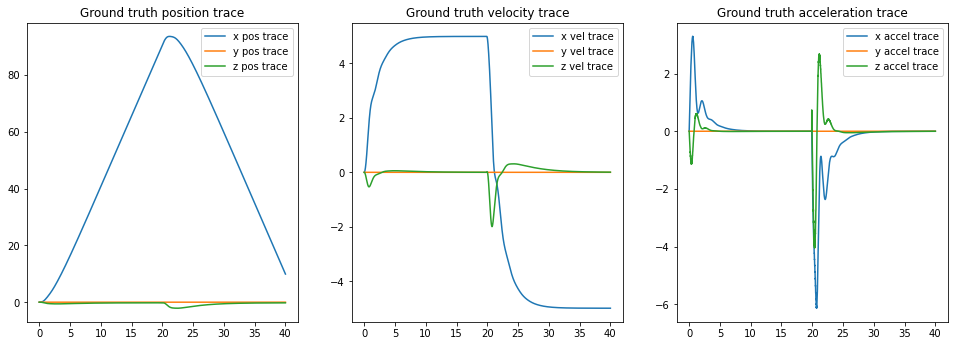

In [7]:
# Let's view ground truth position/velocity/accel

fig,axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x pos trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label='y pos trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label='z pos trace')
axs[0].legend()
axs[0].set_title('Ground truth position trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 1), label='y vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 2), label='z vel trace')
axs[1].legend()
axs[1].set_title('Ground truth velocity trace')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 0), label='x accel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 1), label='y accel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 2), label='z accel trace')
axs[2].legend()
axs[2].set_title('Ground truth acceleration trace')

plt.show()

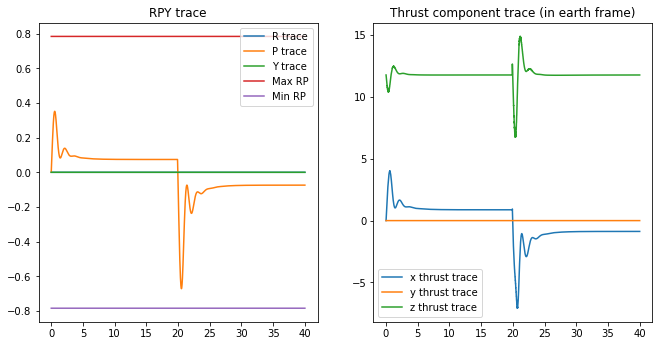

In [8]:
# Let's view ground RPY and Thrust

fig,axs = plt.subplots(ncols=2, figsize=(11,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 0), label='R trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 1), label='P trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 2), label='Y trace')
max_rpy_array = np.empty(len(AC1_trajectory['time']))
max_rpy_array[:] = AC1_AircraftType.max_roll_pitch
axs[0].plot(AC1_trajectory['time'], max_rpy_array, label='Max RP')
axs[0].plot(AC1_trajectory['time'], -max_rpy_array, label='Min RP')
axs[0].legend()
axs[0].set_title('RPY trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 0), label='x thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 1), label='y thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 2), label='z thrust trace')
axs[1].legend()
axs[1].set_title('Thrust component trace (in earth frame)')


plt.show()

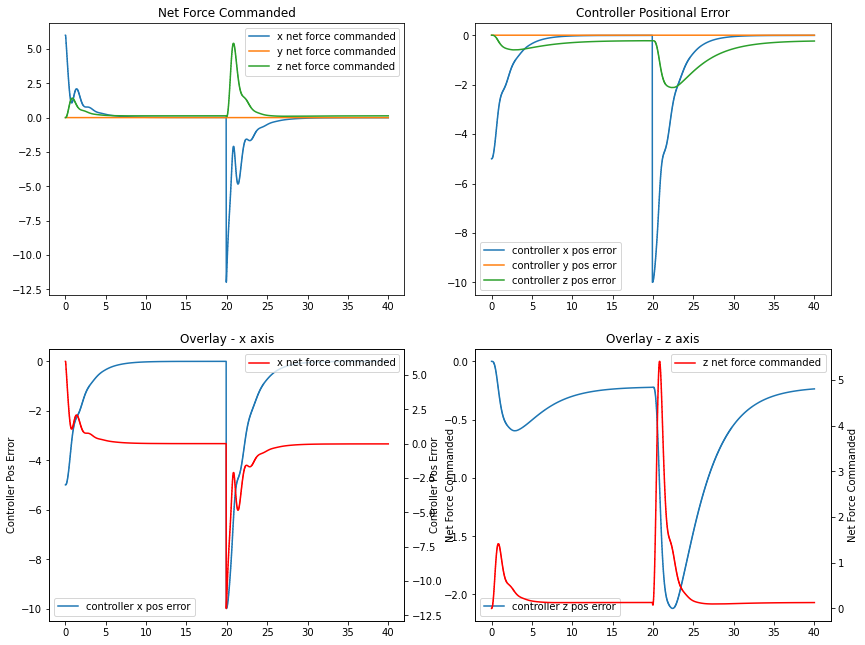

In [9]:
# Let's view ground truth controller error and commanded net force

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(14,11))

axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 1), label='y net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded')
axs[0,0].legend()
axs[0,0].set_title('Net Force Commanded')


axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 1), label='controller y pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[0,1].legend()
axs[0,1].set_title('Controller Positional Error')

axs[1,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[1,0].legend(loc = 'lower left')
axs[1,0].set_ylabel('Controller Pos Error')
axs2 = axs[1,0].twinx()
axs2.set_ylabel('Net Force Commanded')
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded', color='r')
axs2.legend()
axs[1,0].set_title('Overlay - x axis')

axs[1,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[1,1].set_ylabel('Controller Pos Error')
axs[1,1].legend(loc = 'lower left')
axs3 = axs[1,1].twinx()
axs3.set_ylabel('Net Force Commanded')
axs3.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded', color='r')
axs3.legend()
axs[1,1].set_title('Overlay - z axis')


plt.show()

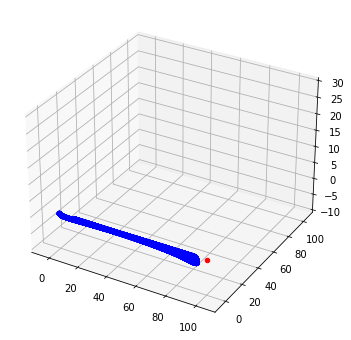

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(extract_from_df(AC1_trajectory, 'gt_pos', 0), 
           extract_from_df(AC1_trajectory, 'gt_pos', 1), 
           extract_from_df(AC1_trajectory, 'gt_pos', 2), c='b')

for wpt in AC1_FlightPlan.plan['Ending Wpt']:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')

xx, tt, zz = AC1_FlightPlan.plan.iloc[0]['Starting Wpt']
ax.scatter(xx, yy, zz, c='r')

    
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)
ax.set_zlim(-10,30)

plt.show()

In [11]:
AC1_FlightPlan.plan.iloc[0]['Starting Wpt']

array([0, 0, 0])